In [ ]:
!pip install torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv


  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_spline_conv-1.2.2.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1104576 sha256=363e91c7e9ade04a3856f0de85bacdf96bf685f169303766fe07c37e5fffd9bc
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl size=728767 sha256=fcc93664ca420b0ced4e0aa5d66bdcc95ef765c9eab03441b70c9f246fcf331f
  Stored in directory: /root/.cache/pip/wheels/51/78/c3/536637b3c

Epoch 1/5, Generator Loss: 5.751154899597168, Discriminator Loss: 0.0302000530064106
Epoch 2/5, Generator Loss: 2.7133564949035645, Discriminator Loss: 0.501265287399292
Epoch 3/5, Generator Loss: 0.5568983554840088, Discriminator Loss: 1.019153356552124
Epoch 4/5, Generator Loss: 2.5832676887512207, Discriminator Loss: 0.16954514384269714
Epoch 5/5, Generator Loss: 3.303921699523926, Discriminator Loss: 0.32379502058029175


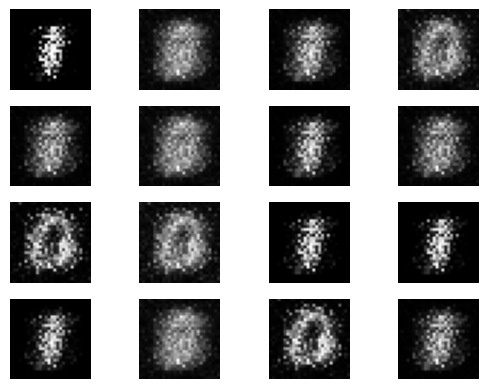

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import struct
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

# Load MNIST images from IDX file
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows * cols)
        return images

# Load MNIST labels from IDX file
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# Generator: Produces fake data
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()  # Scale output between [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

# Discriminator: Distinguishes real vs fake
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, x):
        return self.model(x)

# Load MNIST dataset from .idx files
train_images = load_mnist_images("/content/train-images.idx3-ubyte")
train_labels = load_mnist_labels("/content/train-labels.idx1-ubyte")
test_images = load_mnist_images("/content/t10k-images.idx3-ubyte")
test_labels = load_mnist_labels("/content/t10k-labels.idx1-ubyte")

# Convert to PyTorch tensors and normalize
train_images_tensor = torch.tensor(train_images, dtype=torch.float32) / 255.0  # Normalize images to [0, 1]
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

# Optional: Reshape images to 28x28 pixels
train_images_tensor = train_images_tensor.view(-1, 28, 28)

# Custom Dataset class for MNIST data
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Add channel dimension for grayscale images (1, 28, 28)
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        return image.view(-1), label  # Flatten image for GAN

# Define a transform to normalize to [-1, 1] for GANs
transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Create Dataset and DataLoader
train_dataset = MNISTDataset(train_images_tensor, train_labels_tensor, transform=transform)
data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize models
noise_dim = 100  # Dimension of the noise vector
data_dim = 784  # Flattened MNIST images (28x28)
generator = Generator(noise_dim, data_dim)
discriminator = Discriminator(data_dim)

# Loss and optimizers
criterion = nn.BCELoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for real_images, _ in data_loader:
        batch_size = real_images.size(0)
        real_data = real_images  # No need to flatten as it is already flattened
        real_labels = torch.ones((batch_size, 1))
        fake_labels = torch.zeros((batch_size, 1))

        # Step 1: Train Discriminator
        noise = torch.randn((batch_size, noise_dim))
        fake_data = generator(noise).detach()

        # Discriminator loss
        real_loss = criterion(discriminator(real_data), real_labels)
        fake_loss = criterion(discriminator(fake_data), fake_labels)
        disc_loss = real_loss + fake_loss

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # Step 2: Train Generator
        noise = torch.randn((batch_size, noise_dim))
        fake_data = generator(noise)
        gen_loss = criterion(discriminator(fake_data), real_labels)  # Fool the discriminator

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

    # Logging
    print(f"Epoch {epoch+1}/{num_epochs}, Generator Loss: {gen_loss.item()}, Discriminator Loss: {disc_loss.item()}")

# Generate fake data
with torch.no_grad():
    noise = torch.randn((16, noise_dim))  # Generate 16 random noise vectors
    generated_data = generator(noise)

# Reshape for visualization
generated_images = generated_data.view(-1, 1, 28, 28)

# Visualize generated samples
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i][0].numpy(), cmap='gray')
    plt.axis('off')
plt.show()
